In [1]:
import numpy as np
import drjit as dr
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import LambertianPattern, DirectivePattern, BackscatteringPattern,\
                      load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, cpx_abs, cpx_convert

no_preview = False # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization
from sionna.rt import Camera
from BeamformingCalc2 import svd_bf, nulling_bf
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, watt_to_dbm,\
                      RadioMapSolver, PathSolver

In [2]:
# scenegen bbox -105.097 40.0371 -105.06 40.0697 --data-dir scenes/Denver
# scene = load_scene("Denver/denver.xml")

# scene = load_scene("boulder_plane_itu2/boulder_plane_itu.xml")
# scene = load_scene("Denver_Scene/Boulder2_2/Boulder2.xml")
scene = load_scene("../blouder_plane_itu3/boulder_plane_itu.xml")
# scene = load_scene("blouder_plane/boulder_plane_itu.xml")

In [3]:

nbs = 1            # Number of gNB/base stations
nsect = 3   # Usually 3, for sector-based coverage

# sec1
p1 = [-438.86474609, 954.68139648, 1.88]

p2 = [-310.86474609, -926.31860352, 1.88]
p3 = [1253.13525391, -213.31860352, 1.88]

tx_pos = [[0,0,45]]
rx_pos = np.array([p3,  p1, p2])

In [4]:
tx_rows = 32
tx_cols = 32
tx_antennas = tx_rows*tx_cols
rx_rows = 1
rx_cols = 2
display_bs_radius= 55
display_vic_radius = 30
display_tn_radius = 45
scene.bandwidth = 100e6
scene.frequency = 9.99e9
for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name)   
    
scene.tx_array = PlanarArray(
    num_rows = tx_rows,
    num_cols = tx_cols,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    polarization="V",
    pattern="tr38901"
)
scene.rx_array = PlanarArray(num_rows=rx_rows,
                             num_cols=rx_cols,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")
for i in range(nbs):
    for s in range(nsect):
        yaw = 2.0 * np.pi * s / nsect
        tx = sionna.rt.Transmitter(
            name=f"tx-{s}",
            position=tx_pos[i],
            power_dbm=30,
            color=(0.0, 0.0, 0.0),
            display_radius=display_bs_radius,
            # orientation=[yaw, 0, -0.1745329252]
            orientation=[yaw, 0, -0.0873]
            )
        scene.add(tx)
        
# num_rx = bs_tn_pos.shape[0]
colors = [(0, 0, 1), (0.0, 1.0, 0.0),(0, 1, 1)]
num_rx = rx_pos.shape[0]
for i in range(num_rx):
    rx_position = rx_pos[i]
    rx = sionna.rt.Receiver(
        name=f"rx-{i}",
        position=rx_position,  
        color=colors[i % len(colors)],
        display_radius=display_vic_radius,
    )
    scene.add(rx)
    rx.look_at(tx)
    



In [5]:
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=3,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)
a, tau = paths.cir(normalize_delays=False, out_type="numpy")

In [6]:
w_t_record = [] 
# a in shape of [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths,1]
h_all = np.sum(a, axis = 4).squeeze() #add all paths
for t in range(nbs * nsect):  # Iterate over all tn-users
    h = h_all[t, :, t ,:].T  
    w_t, w_r = svd_bf(h,tx_antennas)
    v_t = np.conj(w_t)
    w_t_record.append(v_t.copy())


In [7]:
v_t = np.array(w_t_record).squeeze(-1)

In [8]:
w_t= v_t
# w_t[:3] = w_t[[0,1,2]]
precoding_vec_real = mi.TensorXf(w_t.real)
precoding_vec_imag = mi.TensorXf(w_t.imag)

precoding_vec = (precoding_vec_real, 
                 precoding_vec_imag)

# precoding_vec = (precoding_vec_imag, 
#                  precoding_vec_real)
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=3,           # Maximum number of ray scene interactions
               samples_per_tx=10**9 , # If you increase: less noise, but more memory required
               precoding_vec=precoding_vec,
               cell_size=(10, 10),      # Resolution of the radio map
               center=[0, 0, 0.1],      # Center of the radio map
               size=[6000, 6000],       # Total size of the radio map
               orientation=[0, 0, 0])
# rm.show(metric="path_gain" );



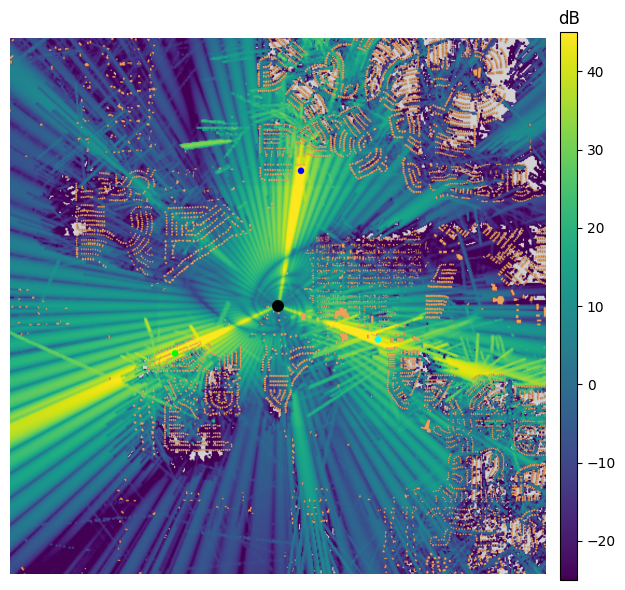

In [9]:


my_cam = Camera(position=[0,0, 6000], look_at=[0, 0, 0])

scene.render(camera=my_cam,
              radio_map= rm,
                #    paths=paths,
                   resolution=(8000, 8000),
                   rm_show_color_bar=True,
                   rm_vmin = -25,
                   rm_vmax = 45,
                   rm_metric='inr',
                   num_samples=64);

In [10]:
scene.preview( paths = paths,clip_at=None, show_devices=True);